# Hand-written digit classification by different classification methods
#### Version 1 (Aug 2020) / tested for python 3.7.6

### General information

***Goal:*** Implementation of different classification models and comparison of their performance in predicting the correct digit from given images containing hand-written digits.

***Note:*** In this current version I implemented only multiclass (OvR) logistic regression with its performance analysis. In the next version I plan to add more classification models (SVM, kNN, Neural network), analyze their performances and compare between them.

***Dataset:*** Images are taken from the MNIST handwritten digit database (loaded via sklearn.datasets)


***Logistic regression model parameters:***
- multi-class technique: One-Vs-Rest
- optimization algorithm: L-BFGS
- regularization method: L2/RIDGE

In [1]:
import pandas as pd
import numpy as np
import math
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['figure.dpi'] = 100

### Get data

In [2]:
# Takes about a min to load...
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)

### Inspect data

In [3]:
def display_data(array, example_width=None):
    """
    Plots images from array (rows=images, columns=pixels)
    :param array: images-array of m images (rows) x n pixels (cols)
    :param example_width: number of pixels in an image's row (optional)
    :return: display_array: matrix containing all images for visualization
    """
    [m, n] = array.shape
    try:
        example_height = int(n / example_width)
    except TypeError:
        example_width = int(round(math.sqrt(array.shape[1] - 1)))
        example_height = int(n / example_width)

    display_rows = math.floor(np.sqrt(m))
    display_cols = math.ceil(m / display_rows)
    filler = 1
    display_array = - np.ones(
        (filler + display_rows * (example_height + filler), filler + display_cols * (example_width + filler)))

    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex + 1 > m:
                break
            max_val = max(abs(array[curr_ex, :]))

            row_start = filler + j * (example_height + filler)
            row_end = filler + j * (example_height + filler) + example_height
            col_start = filler + i * (example_width + filler)
            col_end = filler + i * (example_width + filler) + example_width

            display_array[row_start:row_end, col_start:col_end] = \
                np.reshape(array[curr_ex, :], (example_height, example_width)) / max_val

            curr_ex += 1

        if curr_ex + 1 > m:
            break

    plt.imshow(display_array, cmap='gray', vmin=-1, vmax=1)  # cmap=plt.cm.binary
    plt.axis('off')
    plt.show()


[1 7 2 5 8 6 4 4 8 8 4 4 8 8 6 5 2 3 8 2 9 1 5 1 8]


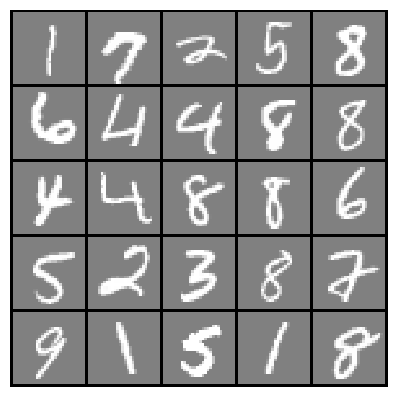

In [4]:
# plot randomly selected images from the dataset

imgs_num = 25  # number of images to be shown
rand_imgs = np.random.permutation(mnist.data.shape[0])[0:imgs_num] 
print(mnist.target[rand_imgs])  # print images' labels (classes)
display_data(mnist.data[rand_imgs, :])

### Check if classes are balanced

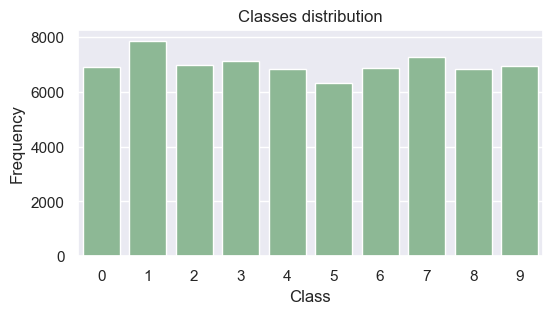

In [5]:
plt.figure(figsize=(6,3))
sns.countplot(x=mnist.target, palette=['#86bf91'])
plt.xlabel("Class")
plt.title("Classes distribution")
plt.ylabel("Frequency");

### Data pre-processing

In [6]:
# pre-training steps
data_mat = np.column_stack([mnist.target, mnist.data])
np.random.shuffle(data_mat)  # randomly shuffle the dataset
y = data_mat[:,0]
X = data_mat[:,1:]
X_norm = X / np.abs(X).max(axis=1).reshape(len(X),1)  # normalize values
X_train, X_validate, X_test = np.split(X_norm, [int(len(X_norm)*0.6), int(len(X_norm)*0.8)])  # split X to train/val/test arrays (0.6/0.2/0.2 ratio)
y_train, y_validate, y_test = np.split(y, [int(len(y)*0.6), int(len(y)*0.8)])  # split y to similar groups as X

## Implementing logistic regression

In [8]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=400, random_state=0, multi_class='ovr')
model = clf.fit(X_train, y_train)

### Measuring multiclass classifier perfromance

In [9]:
# model's accuracy 
clf.score(X_validate, y_validate)  # equal to sklearn.metrics.accuracy_score function

0.9150714285714285

#### Confusion matrix

In [10]:
from sklearn import metrics

def confus_matr(actual_y, predicted_y):
    n_classes = len(np.unique(y_validate))
    cm = metrics.confusion_matrix(actual_y, predicted_y)
    cm_df = pd.DataFrame(cm)
    col_list = ['Predicted ' + str(i) for i in range(n_classes)]
    cm_df.columns = col_list
    indices = {i: 'Actual ' + str(i) for i in range(n_classes)}
    cm_df = cm_df.rename(index=indices)
    return cm_df

# generate readable confusion matrix for the actual vs. predicted classes
cm_df = confus_matr(y_validate, model.predict(X_validate))
cm_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,1313,0,5,3,4,6,8,0,6,1
Actual 1,1,1549,7,2,1,7,2,3,12,2
Actual 2,10,10,1279,18,24,3,15,22,45,1
Actual 3,7,7,34,1301,2,31,6,15,42,9
Actual 4,3,5,9,4,1209,1,9,2,17,33
Actual 5,19,9,8,54,20,1115,30,7,38,11
Actual 6,8,7,8,2,15,26,1298,2,9,0
Actual 7,6,9,21,5,16,3,0,1416,5,36
Actual 8,11,35,16,30,15,41,11,9,1143,26
Actual 9,11,7,6,24,49,10,0,46,14,1188


#### Measuring recall/precision separately for each class

In [11]:
performance = pd.DataFrame(np.unique(y_validate), columns=['Classes'])

def measure_recall(row):
    row['Classes']
    result = (model.predict(X_validate[y_validate == row['Classes']]) == row['Classes']).sum() / len(model.predict(X_validate[y_validate == row['Classes']]))  # TP / (TP + FN)  ("recall", "sensitivity")
    return result

def measure_precision(row):
    row['Classes']
    result = (model.predict(X_validate[y_validate == row['Classes']]) == row['Classes']).sum() / (model.predict(X_validate) == 1).sum()  # TP / (TP + FP)  ("precision", "positive predictive value")
    return result

performance['Recall'] = performance.apply(lambda row: measure_recall(row), axis=1)
performance['Precision'] = performance.apply(lambda row: measure_precision(row), axis=1)
performance

,Classes,Recall,Precision
0,0.0,0.975483,0.801587
1,1.0,0.976671,0.945665
2,2.0,0.896286,0.780830
3,3.0,0.894773,0.794261
4,4.0,0.935759,0.738095
5,5.0,0.850496,0.680708
6,6.0,0.944000,0.792430
7,7.0,0.933421,0.864469
8,8.0,0.854899,0.697802
9,9.0,0.876753,0.725275


#### Area under the precision-recall curve (AUCPR), plotted individually for each class (f1-scores areas defined by gray lines) 

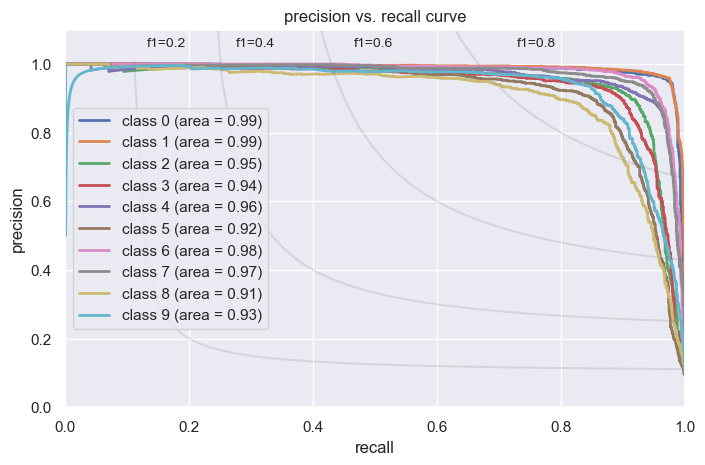

In [12]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

n_classes = len(np.unique(y_validate))
y_score = clf.predict_proba(X_validate)

# Use label_binarize to be multi-label like settings
y_binarized = label_binarize(y_validate, classes=np.unique(y_validate))

# precision recall curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_binarized[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_binarized[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
    
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(y[45] + 0.02, 1.05))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

#### Overall performance of the multiclass model

#### Checking classes distribution to decide whether to use micro or macro average for overall recall & precision calculations

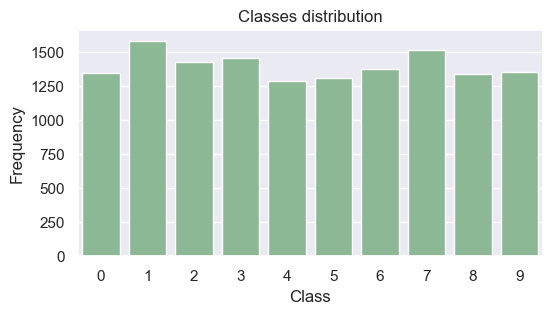

In [14]:
plt.figure(figsize=(6,3))
sns.countplot(x=y_validate.astype(int), palette=['#86bf91'])
plt.xlabel("Class")
plt.title("Classes distribution")
plt.ylabel("Frequency"); 

#### Classes are similarly distributed, thus micro-average can be used for performance measures:

#### Micro-averaged Precision-Recall curve & score 

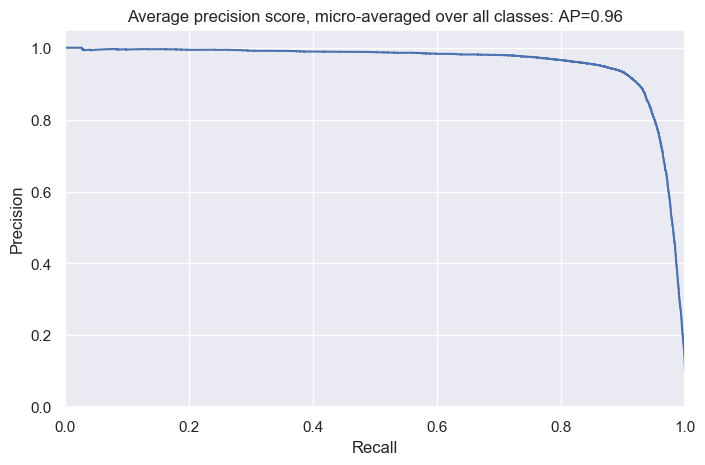

In [15]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_binarized.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_binarized, y_score, average="micro")

# Plot the micro-averaged Precision-Recall curve
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]))
plt.show()

### Inspecting false negatives for a chosen class

False negatives for class=1:
[5 7 2 2 0 5 7 6 8 2 4 5 5 6 8 5 2 2 9 5 2 3 8 8 8 8 8 8 8 8 2 3 9 7 5 8 8]


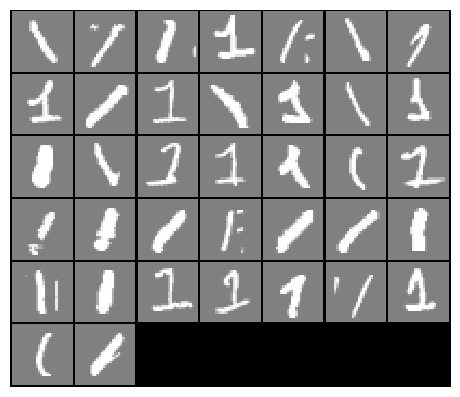

In [18]:
inspected_class = 1
false_negatives = model.predict(X_validate[y_validate == inspected_class]) != inspected_class
print('False negatives for class={}:'.format(str(inspected_class)))
print(model.predict(X_validate[y_validate == inspected_class][false_negatives]).astype(int))
display_data(X_validate[y_validate == inspected_class][false_negatives]) 

## Next steps for the logistic model:
- using the validation set outputs to improve the logistic model 
- show optimal performance of the logistic model on the test set

## Next steps following the logistic model:
- implementing other classification models: kNN, SVM w/wo gaussian kernel, Neural network (others methods?...)
- improve models
- compare algorithms performance